## Decision Trees

## Set up data

In [13]:
# Load essential libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

# Read csv file
df = pd.read_csv('../data/cleaned_wf_demo.csv')
print(df.head())

   Unnamed: 0         company            region  seniority job_category  \
0           1  The Home Depot  Northern America          2        empty   
1           2  The Home Depot  Northern America          2        Sales   
2           3  The Home Depot  Northern America          3     Engineer   
3           4  The Home Depot  Northern America          1    Scientist   
4           5  The Home Depot  Northern America          2        Admin   

   gender ethnicity       count    inflow   outflow        salary  year  
0    male  multiple    1.339059  0.000470  0.008150  9.310531e+04  2020  
1  female    native   30.866820  0.462686  0.081448  1.952310e+06  2020  
2  female     white  229.514520  2.762419  5.267294  2.229767e+07  2020  
3  female    native    1.413377  0.000212  0.009232  6.196394e+04  2020  
4    male    native    2.650784  0.016046  0.008234  1.946259e+05  2020  


## Reorganize data for Decision Trees

In [15]:
## SET X AND Y

# y: CONVERT FROM STRING LABELS TO INTEGERS 
labels=[]; 
y=[]
for label in df["company"]:
    if label not in labels:
        labels.append(label)
        print("index =",len(labels)-1,": label =",label)
    for i in range(0,len(labels)):
        if(label==labels[i]):
            y.append(i)
y = np.array(y)

# X
X = df.drop(['company', 'region'], axis = 1)

# Double check
print(X.shape,y.shape)

index = 0 : label = The Home Depot
index = 1 : label = Databricks
index = 2 : label = Bristol Myers Squibb Co.
index = 3 : label = Accenture Plc
index = 4 : label = Apple
index = 5 : label = The Goldman Sachs Group
(42336, 10) (42336,)


In [16]:
# Load sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Partion data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=4)

# Check 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(33868, 10)
(33868,)
(8468, 10)
(8468,)


## Support Vector Classifier

In [17]:
# Initialize model

# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Fit model
fit1 = DecisionTreeClassifier(random_state=0)

fit1

DecisionTreeClassifier(random_state=0)

In [18]:

# Fit to training data
from sklearn.utils.fixes import sklearn

fit1.fit(X_train, y_train) 

# USE ONE-HOT ENCODER TO CONVERT STRING TO FLOAT
# Predict on X_train
y_train_pred = fit1.predict(X_train)

ValueError: could not convert string to float: 'Operations'

In [42]:
# TEST ACCURACY
# Training set
print("Training set")
print("Accuracy: ", accuracy_score(y_train, y_train_pred) * 100) #accuracy score
print("Number of mislabeled points out of a total 4275 points: ", (y_train != y_train_pred).sum()) #mislabeled points

# Test set
y_test_pred = fit1.predict(X_test)
print("Test set")
print("Accuracy: ", accuracy_score(y_test, y_test_pred)*100) #accuracy score
print("Number of mislabeled points out of a total 1069 points: ", (y_test != y_test_pred).sum()) #mislabeled points

Training set
Accuracy:  67.15823970037454
Number of mislabeled points out of a total 4275 points:  1403
Test set
Accuracy:  64.26566884939196
Number of mislabeled points out of a total 1069 points:  382


## Visualize data

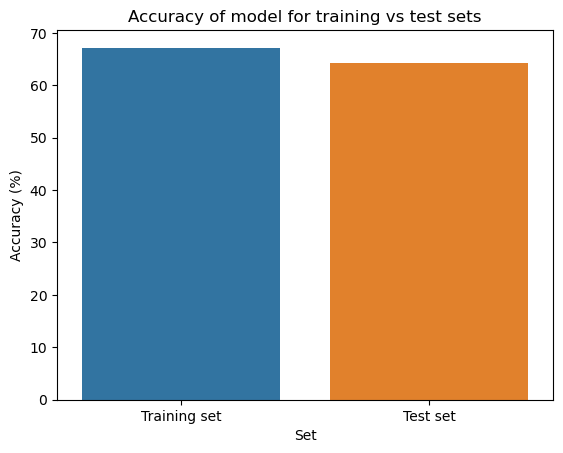

In [43]:
model_accuracies = pd.DataFrame({'Set':['Training set','Test set'], 'Accuracy (%)': [accuracy_score(y_train, y_train_pred) * 100, accuracy_score(y_test, y_test_pred)*100]})
sns.barplot(data=model_accuracies, x="Set", y="Accuracy (%)").set(title = 'Accuracy of model for training vs test sets' )

# Save plot
plt.savefig("../501-project-website/images/DT_tweets_accuracy.png")

## Confusion matrix

/Users/cynthiang/opt/anaconda3/envs/class/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


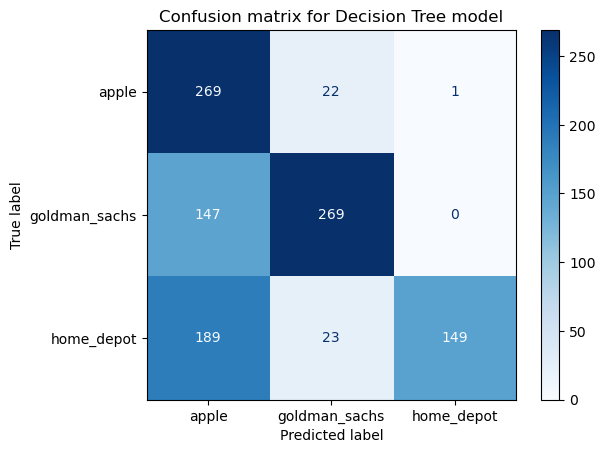

In [44]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(fit1 , X_test ,  y_test ,  cmap="Blues")

# Plot confusion matrix
plt.title("Confusion matrix for Decision Tree model")

# Save confusion matrix plot
plt.savefig("../501-project-website/images/DT_tweets_confusion_matrix.png")